In [245]:
import json
import importlib
import os
import sys
import xml
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.utils import parse_lipid, parse_p_value, tight_bbox
from src import plots
import src.Fig4_subplots
importlib.reload(plots)

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'

plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6

from sklearn.preprocessing import StandardScaler
import networkx as nx
from scipy.cluster.hierarchy import linkage
from scipy.stats import pearsonr, spearmanr
# import pylustrator

In [6]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

In [174]:
id_lipids_idx = data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'Unidentified')].index

data.loc[id_lipids_idx, 'fa_unsat'] = data.loc[id_lipids_idx, 'ID'].apply(lambda x: parse_lipid(x)[3])
data.loc[id_lipids_idx, 'fa_len'] = data.loc[id_lipids_idx, 'ID'].apply(lambda x: parse_lipid(x)[2])

In [487]:
ldf = data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'Unidentified'), rbg_cols]
lipids_idx = ldf.index

lu = UMAP(n_neighbors=15, n_components=5, metric='cosine', min_dist=0.9, random_state=43)\
        .fit_transform(StandardScaler().fit_transform(ldf)) 
l = pd.DataFrame(lu, columns=[f'd{x+1}' for x in range(lu.shape[1])], index=lipids_idx)\
      .join(data[['fa_unsat', 'fa_len', 'molec_class', 'superclass']])

pca = PCA(n_components=5)

lpca = pca.fit_transform(StandardScaler().fit_transform(ldf))
apca = pca.fit_transform(StandardScaler().fit_transform(adf))
rpca = pca.fit_transform(StandardScaler().fit_transform(rdf))
fpca = pca.fit_transform(StandardScaler().fit_transform(fdf))

lpca = pd.DataFrame(lpca, columns=[f'd{x+1}' for x in range(lpca.shape[1])], index=lipids_idx).join(data[['fa_unsat', 'fa_len', 'superclass', 'molec_class']])
apca = pd.DataFrame(apca, columns=[f'd{x+1}' for x in range(apca.shape[1])], index=tgs_idx).join(data[['fa_unsat', 'fa_len']])
rpca = pd.DataFrame(rpca, columns=[f'd{x+1}' for x in range(rpca.shape[1])], index=tgs_idx).join(data[['fa_unsat', 'fa_len']])
fpca = pd.DataFrame(fpca, columns=[f'd{x+1}' for x in range(fpca.shape[1])], index=tgs_idx).join(data[['fa_unsat', 'fa_len']])

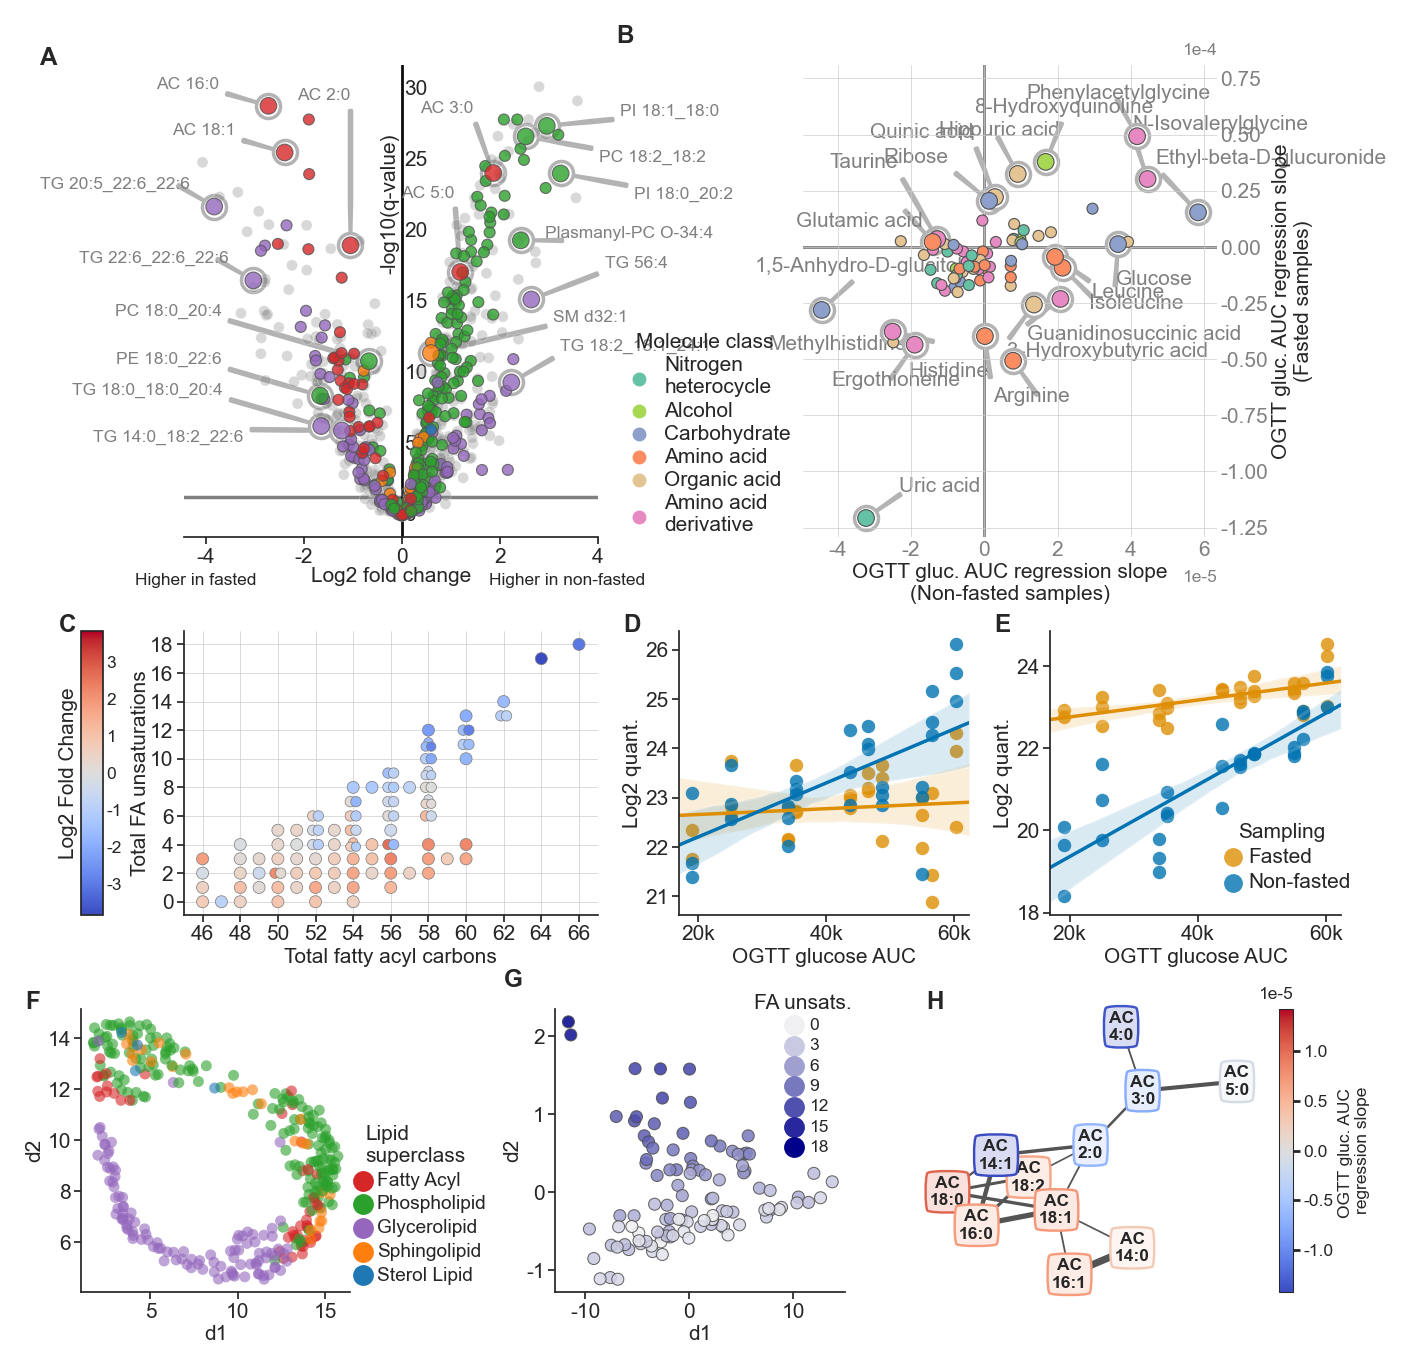

In [569]:
# plt.rcParams['xtick.major.pad'] = 1
# plt.rcParams['xtick.major.size'] = 0.0
# plt.rcParams['xtick.major.width'] = 1
plt.rcParams['axes.labelpad'] = 1
# plt.rcParams['axes.spines.right'] = 0
# plt.rcParams['axes.spines.top'] = 0
# plt.rcParams['lines.markersize'] = 5
importlib.reload(src.Fig4_subplots)
importlib.reload(src.plots)
fig, axs = plt.subplot_mosaic(
    """
    .AAAA.BBBB.
    .AAAA.BBBB.
    .AAAA.BBBB.
    cCCCCDDDEEE
    cCCCCDDDEEE
    FFF.GGGHHHH
    FFF.GGGHHHH
    """,
    gridspec_kw=dict(hspace=1, wspace=2, 
                     width_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    ),
    figsize=(6.5, 6.5), dpi=250, facecolor='white',
)
# SET SPINE WIDTHS FOR ALL AXES
for ax in axs.values():
    ax.tick_params(length=2, pad=1, labelsize=6, width=0.5)
    for side in ['top','bottom','left','right']:
        ax.spines[side].set_linewidth(0.5)

src.Fig4_subplots.lipid_volcano_plot(ax=axs['A'])
axs['A'].set_xlabel('Log2 fold change', fontsize=6, labelpad=0)
axs['A'].set_xticks([-4, -2, 0, 2, 4])

src.Fig4_subplots.metab_coef_coef_plot(ax=axs['B'])
axs['B'].set_ylim(top=axs['B'].get_ylim()[1] * 1.4)

axc, cbar = src.Fig4_subplots.make_carbon_unsat_plot('TG', 0.15, ax=axs['C'], cax=axs['c'], base_size=12)
# axc.tick_params(pad=1, length=2, labelsize=5)
axc.grid(linewidth=0.2)
axc.set_ylabel('Total FA unsaturations', fontsize=6, labelpad=0)
cbar.ax.tick_params(pad=1, length=0, labelsize=5)
cbar.ax.set_ylabel('Log2 Fold Change')
cbar.ax.yaxis.set_label_position('left')
cbar.outline.set_linewidth(0.5)

tg05 = data.loc[(data['molec_class'] == 'TG') & (data['fa_unsat'] < 6)].index
tg10 = data.loc[(data['molec_class'] == 'TG') & (data['fa_unsat'] > 9)].index
src.plots.plot_quant_vs_ogtt(feature=tg05, ax=axs['D'], scatter_kws=dict(s=15, lw=0), line_kws=dict(lw=1))
src.plots.plot_quant_vs_ogtt(feature=tg10, ax=axs['E'], scatter_kws=dict(s=15, lw=0), line_kws=dict(lw=1), 
                             legend=True)
axs['D'].set(ylabel='Log2 quant.', xlabel='OGTT glucose AUC')
axs['E'].set(ylabel='Log2 quant.', xlabel='OGTT glucose AUC')
axs['E'].legend(loc=(0.53, 0.05), handletextpad=-0.3, markerscale=1.4, labelspacing=0.3, title='Sampling', 
                title_fontsize=6, fontsize=6)

sns.scatterplot(
    data=l, x='d1', y='d2', hue='superclass', ax=axs['F'], s=10,
    alpha=0.6, edgecolor='0.3', linewidth=0, palette=colors,)
sns.scatterplot(
    data=rpca, x='d1', y='d2', hue='fa_unsat', ax=axs['G'],
    palette=sns.light_palette('darkblue', as_cmap=True), 
    alpha=0.85, edgecolor='0.3', linewidth=0.3, s=12)
# sns.scatterplot(
#     data=rpca, x='d1', y='d2', hue='fa_len', ax=axs['H'], 
#     palette=sns.light_palette('black', as_cmap=True), 
#     alpha=0.6, edgecolor='0.3', linewidth=0.3, s=12)

axs['F'].legend(loc=(0.95, 0), handletextpad=-0.3, markerscale=1, labelspacing=0.3, title='Lipid\nsuperclass', 
           title_fontsize=6, fontsize=5.5)
axs['G'].legend(loc=(0.66, 0.46), handletextpad=-0.1, markerscale=1, labelspacing=0.3, title='FA unsats.', 
           title_fontsize=6, fontsize=5)
# axs['H'].legend(loc=(0.7, 0.45), handletextpad=-0.3, markerscale=1, labelspacing=0.3, title='FA carbons', 
#            title_fontsize=6, fontsize=5.5)

src.plots.plot_graph(metab_set=data.loc[data['molec_class'].isin(['AC'])].index, ax=axs['H'],
                     corr=0.365, corr_type='pearson')
axs['H'].margins(0.02)

for ax in [axs['F'], axs['G']]:
    ax.tick_params(labelsize=6, pad=1, length=2, width=0.5)
    sns.despine(ax=ax)
for ax_letter in ['A', 'B', 'c', 'D', 'E', 'F', 'G', 'H']:
    ax = axs[ax_letter]
    bb = tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1, s=ax_letter.upper(), transform=fig.transFigure, fontweight='bold', fontsize=7)

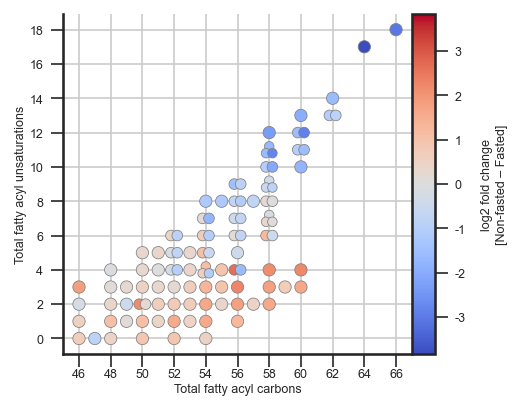

In [312]:
importlib.reload(src.Fig4_subplots)
importlib.reload(src.utils)

_, _ = src.Fig4_subplots.make_carbon_unsat_plot('TG', 0.2, base_size=35)
plt.gcf().set_size_inches(6, 3)

# What happens if you cluster lipid features using UMAP/PCA?

In [399]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [420]:
tgs_idx = data.loc[data['molec_class'] == 'TG'].index
adf = data.loc[tgs_idx, data_cols]
rdf = data.loc[tgs_idx, rbg_cols]
fdf = data.loc[tgs_idx, fbg_cols]

# umap = UMAP(n_neighbors=15, n_components=5, metric='euclidean', random_state=43,)
umap = UMAP(n_neighbors=15, n_components=5, metric='euclidean', random_state=43,)

au = umap.fit_transform(StandardScaler().fit_transform(adf))
ru = umap.fit_transform(StandardScaler().fit_transform(rdf))
fu = umap.fit_transform(StandardScaler().fit_transform(fdf))
                    
a = pd.DataFrame(au, columns=[f'd{x+1}' for x in range(au.shape[1])], index=tgs_idx).join(data[['fa_unsat', 'fa_len']])
r = pd.DataFrame(ru, columns=[f'd{x+1}' for x in range(ru.shape[1])], index=tgs_idx).join(data[['fa_unsat', 'fa_len']])
f = pd.DataFrame(fu, columns=[f'd{x+1}' for x in range(fu.shape[1])], index=tgs_idx).join(data[['fa_unsat', 'fa_len']])

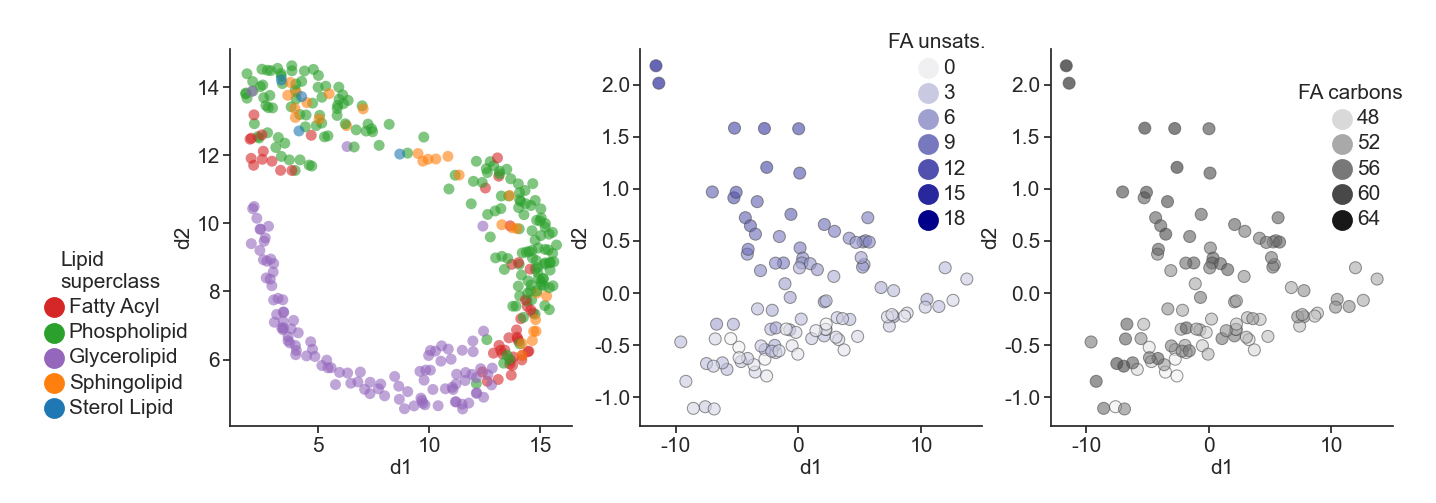

In [526]:
fig, [ax0, ax1, ax2] = plt.subplots(ncols=3, figsize=(6, 2), dpi=250)

sns.scatterplot(
    data=l, x='d1', y='d2', hue='superclass', ax=ax0, s=10,
    alpha=0.6, edgecolor='0.3', linewidth=0, 
    palette=colors,
)
df = rpca
sns.scatterplot(
    data=rpca, x='d1', y='d2', hue='fa_unsat', ax=ax1,
    palette=sns.light_palette('darkblue', as_cmap=True), 
    alpha=0.6, edgecolor='0.3', linewidth=0.3, s=12)
sns.scatterplot(
    data=rpca, x='d1', y='d2', hue='fa_len', ax=ax2, 
    palette=sns.light_palette('black', as_cmap=True), 
    alpha=0.6, edgecolor='0.3', linewidth=0.3, s=12)

ax0.legend(loc=(-0.6, 0), handletextpad=-0.3, markerscale=1, labelspacing=0.3, title='Lipid\nsuperclass', 
           title_fontsize=6, fontsize=6)
ax1.legend(loc=(0.7, 0.5), handletextpad=-0.3, markerscale=1, labelspacing=0.3, title='FA unsats.', 
           title_fontsize=6, fontsize=6)
ax2.legend(loc=(0.7, 0.5), handletextpad=-0.3, markerscale=1, labelspacing=0.3, title='FA carbons', 
           title_fontsize=6, fontsize=6)
for ax in [ax0, ax1, ax2]:
    ax.tick_params(labelsize=6, pad=1, length=2, width=0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

sns.despine()

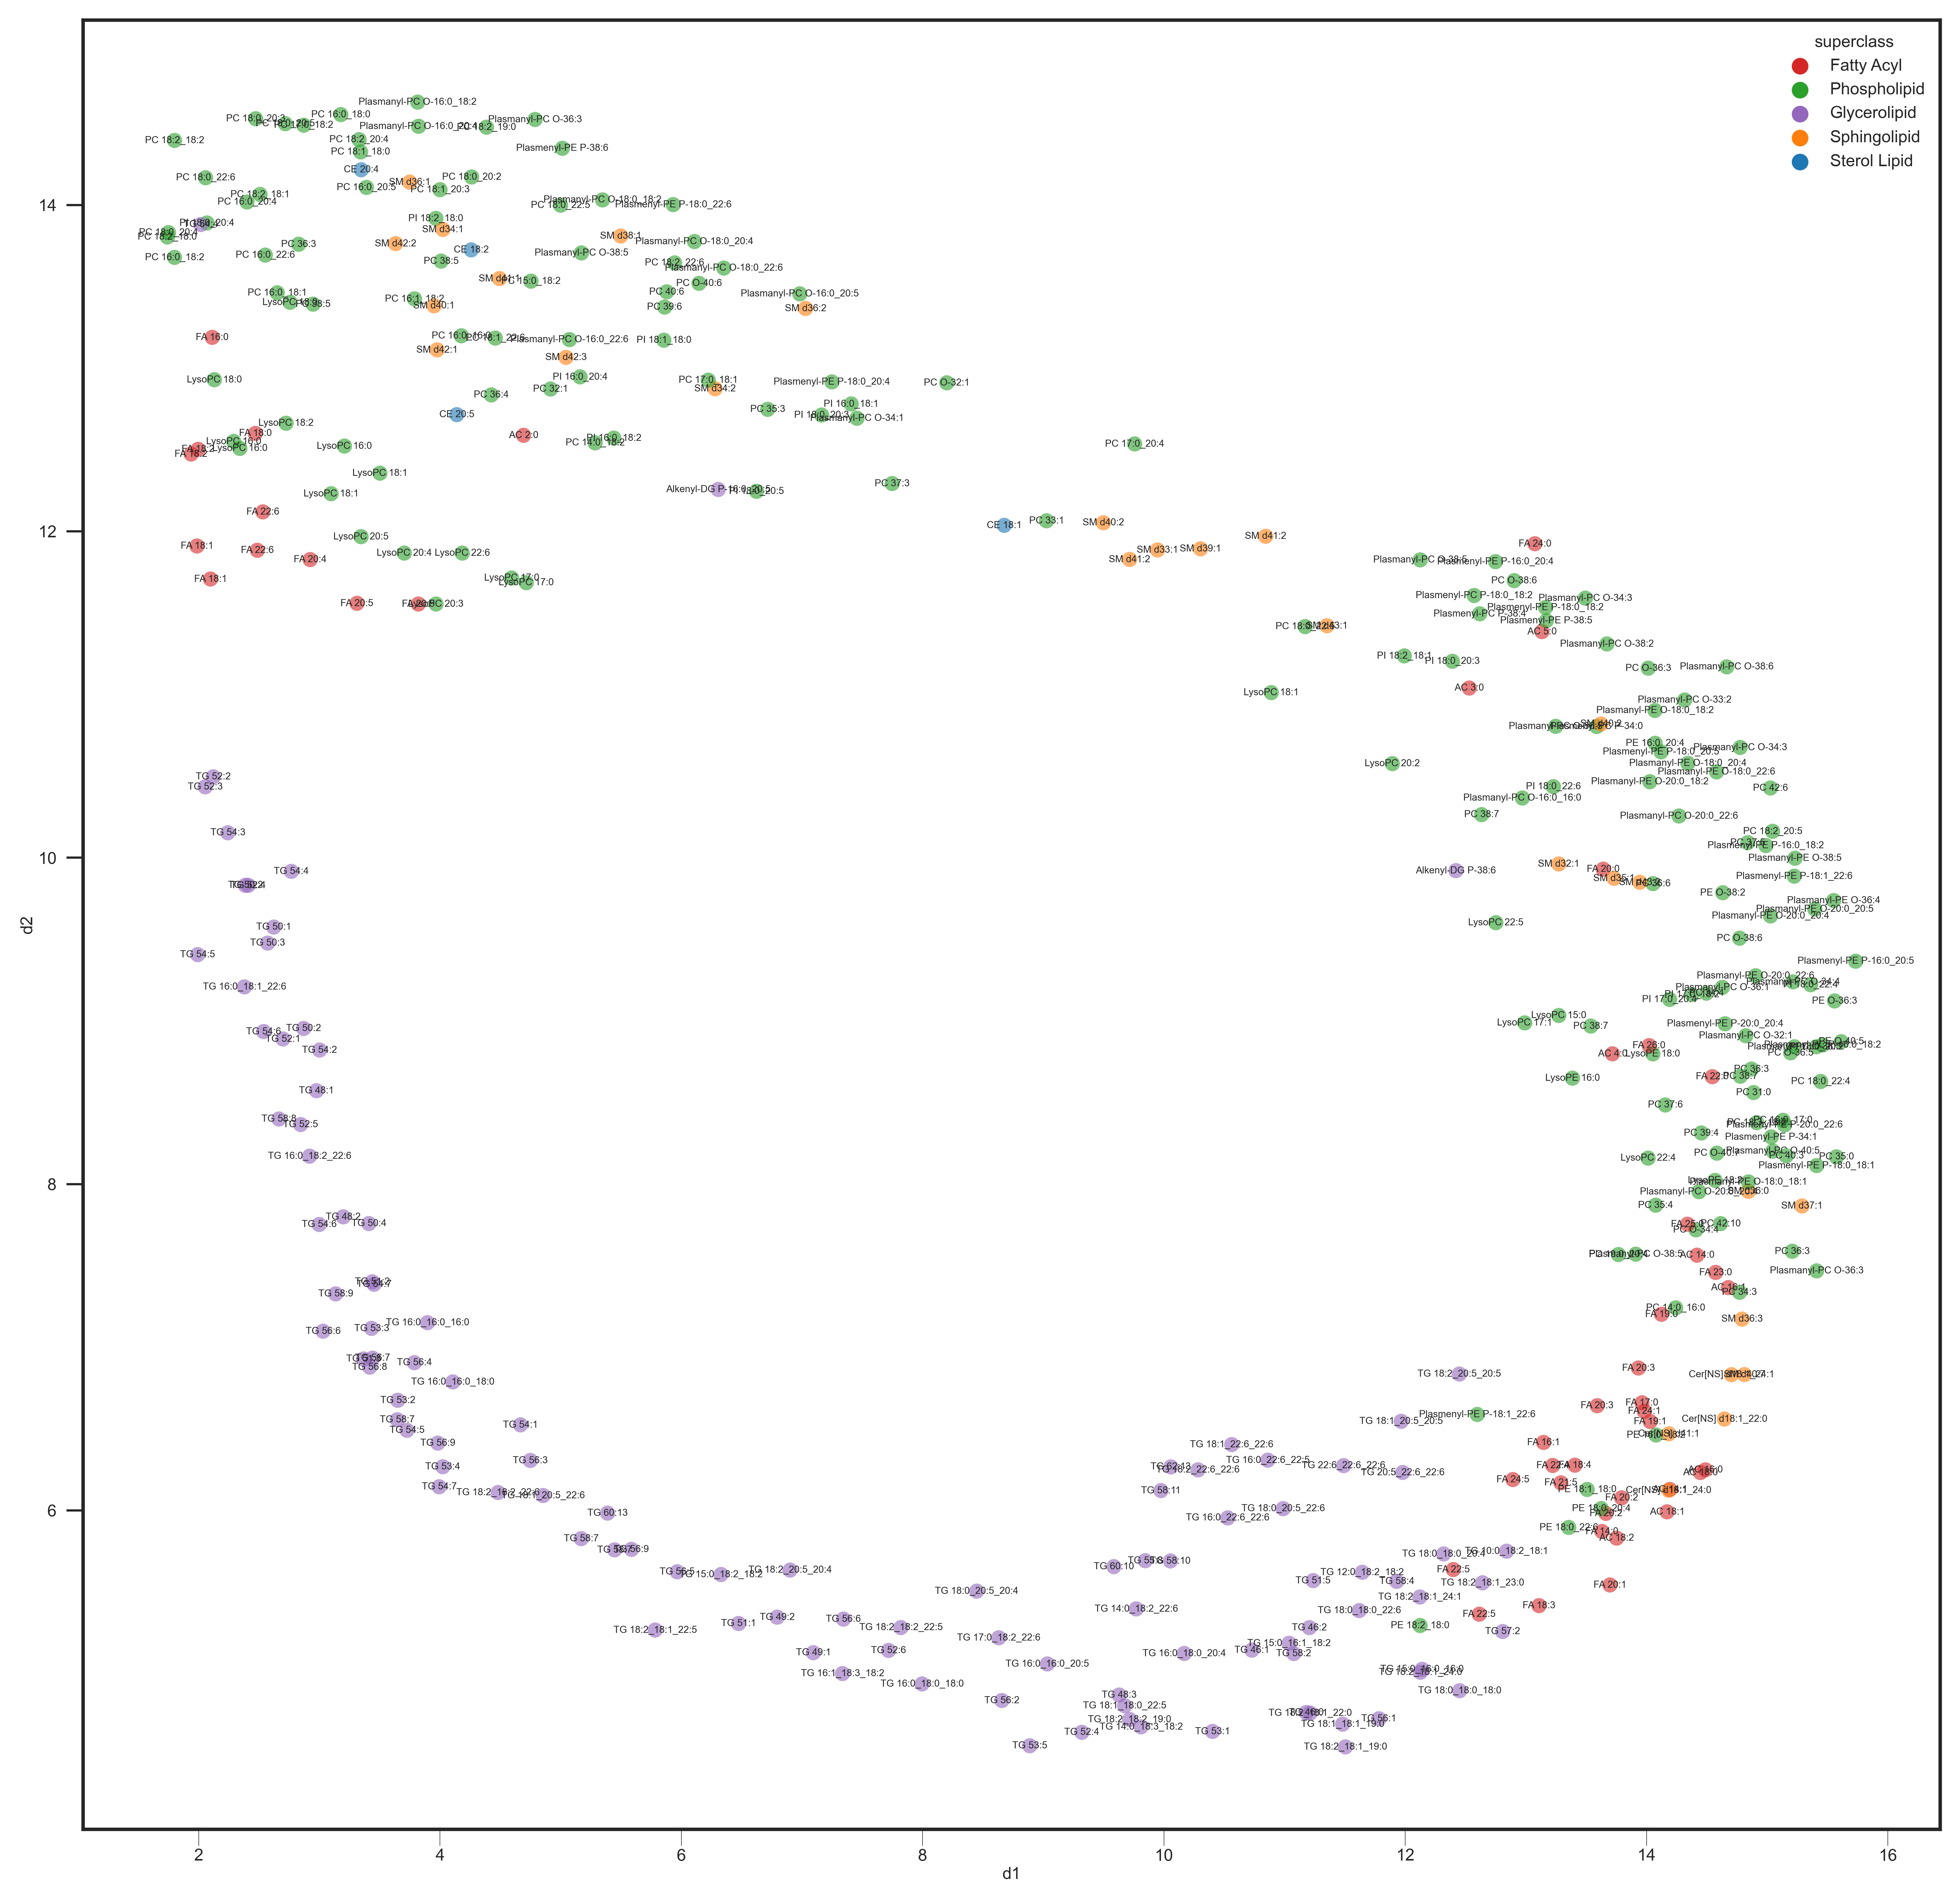

In [512]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=650)
sns.scatterplot(
    data=l, x='d1', y='d2', hue='superclass', ax=ax, s=30,
    alpha=0.6, edgecolor='0.3', linewidth=0, 
    palette=colors,
)
if 'ID' not in l:
    l = l.join(data['ID'])

for i, row in l.iterrows():
    ax.text(row['d1'], row['d2'], row['ID'], fontsize=3.5, ha='center', va='center')